# Predicting a Twitter User's Myers-Briggs Personality Type

The Myers Briggs Type Indicator (or MBTI for short) is a personality type system that divides everyone into 16 distinct personality types across 4 axis:

Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
So for example, someone who prefers introversion, intuition, thinking and perceiving would be labelled an INTP in the MBTI system, and there are lots of personality based components that would model or describe this person’s preferences or behaviour based on the label.

It is one of, if not the, the most popular personality test in the world. It is used in businesses, online, for fun, for research and lots more. A simple google search reveals all of the different ways the test has been used over time. It’s safe to say that this test is still very relevant in the world in terms of its use.

Inspired by: https://www.kaggle.com/stefanbergstein/byo-tweets-predict-your-myers-briggs-personality

Dataset used: https://www.kaggle.com/datasnaek/mbti-type

In [24]:
import pandas as pd
import numpy as np
import re

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [33]:
# Vectorize with count and TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

In [21]:
# read data
data = pd.read_csv('mbti.csv') 

In [55]:
# XGBoost model
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [59]:
# Feature importance with XGBoost
from xgboost import plot_importance

In [66]:
# XGBoost Hyperparameter Tuning
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [69]:
# Twitter data
import twint

## Inspect the data

In [3]:
data.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [10]:
# List of posts
data.iloc(0)[0]['posts'].split('|||')

["'http://www.youtube.com/watch?v=qsXHcwe3krw",
 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
 'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks',
 'What has been the most life-changing experience in your life?',
 'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.',
 'May the PerC Experience immerse you.',
 'The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206',
 "Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...",
 '84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-ho

**Explore the class distributions**

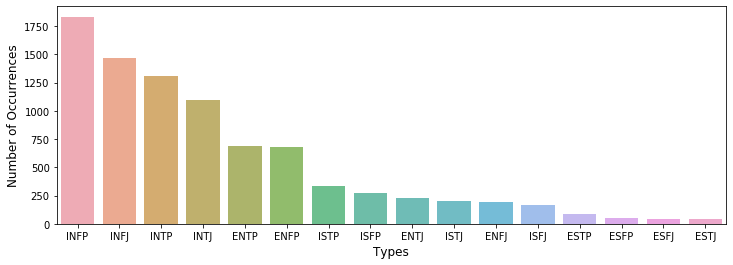

In [11]:
cnt_types = data['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_types.index, cnt_types.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

Add columns for the type indicators (IE, JP, NS, TF)

In [12]:
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E incorrect')
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S incorrect')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F incorrect')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P incorrect')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data.join(data.apply (lambda row: get_types (row),axis=1))
data.head(5)

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


In [13]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) – Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) – Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) – Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 1999  /  6676
Intuition (N) – Sensing (S):		 1197  /  7478
Thinking (T) – Feeling (F):		 4694  /  3981
Judging (J) – Perceiving (P):		 5241  /  3434


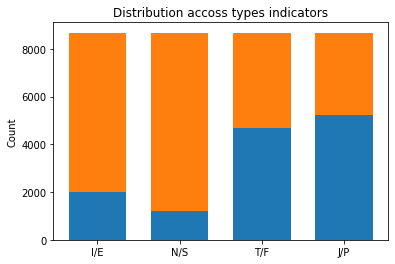

In [14]:
N = 4
but = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
width = 0.7      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, but, width)
p2 = plt.bar(ind, top, width, bottom=but)

plt.ylabel('Count')
plt.title('Distribution accoss types indicators')
plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))

plt.show()

Correlation Matrix

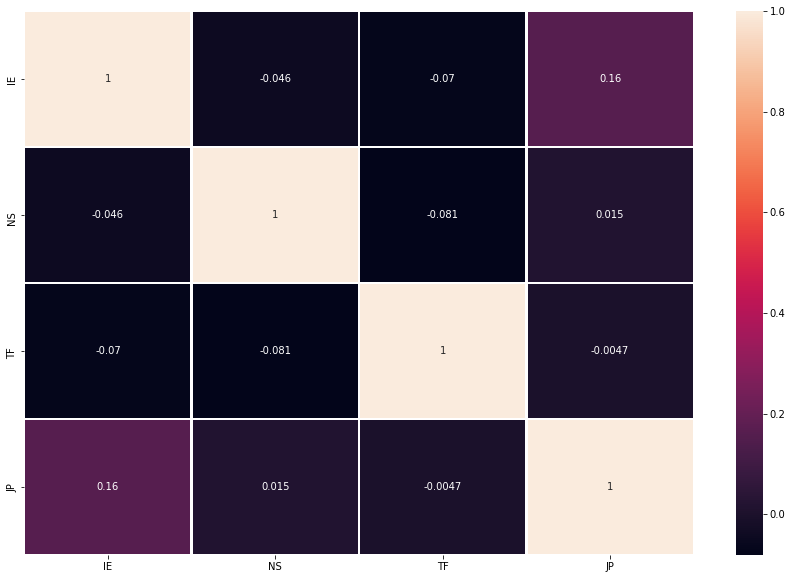

In [16]:
fig, ax = plt.subplots(figsize=(15,10))  
corr=data.corr()
sns.heatmap(corr, annot=True, linewidths=1.5)

## Preparing the data

Binarize Type Inidcator

In [17]:
b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    
    return [b_Pers[l] for l in personality]

def translate_back(personality):
    # transform binary vector to mbti personality
    
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

# Check ...
d = data.head(4)
list_personality_bin = np.array([translate_personality(p) for p in d.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 [0 0 1 0]]


**Pre-process tweets**
- Remove urls
- Keep only words and put everything lowercase
- Lemmatize each word
- Remove MBTI profiles strings. Too many appear in the posts!

In [22]:
# We want to remove these from the psosts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")

def pre_process_data(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        type_labelized = translate_personality(row[1].type)
        list_personality.append(type_labelized)
        list_posts.append(temp)

    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

In [26]:
list_posts, list_personality = pre_process_data(data, remove_stop_words=True)

1 of 8675 rows
500 of 8675 rows
1000 of 8675 rows
1500 of 8675 rows
2000 of 8675 rows
2500 of 8675 rows
3000 of 8675 rows
3500 of 8675 rows
4000 of 8675 rows
4500 of 8675 rows
5000 of 8675 rows
5500 of 8675 rows
6000 of 8675 rows
6500 of 8675 rows
7000 of 8675 rows
7500 of 8675 rows
8000 of 8675 rows
8500 of 8675 rows
8675 of 8675 rows


In [32]:
list_posts[0]

'   moment sportscenter top ten play prank life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace hello  sorry hear distress natural relationship perfection time every moment existence try figure hard time time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg mean moving sitting desk chair weed moderation maybe try edible healthier alternative basically come three item determined type whichever type want would likely use given type cognitive function whatnot left thing moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video game growing current favorite video game cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always around yo  lady complimentary personality well h

In [29]:
list_personality

array([[0, 0, 0, 0],
       [1, 0, 1, 1],
       [0, 0, 1, 1],
       ...,
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

**Vectorize with count and tf-idf**
<br>Keep words appearing in 10% to 70% of the posts

In [34]:
# Posts to a matrix of token counts
cntizer = CountVectorizer(analyzer="word",
                          max_features=1500,
                          tokenizer=None,
                          preprocessor=None,
                          stop_words=None,
                          max_df=0.7,
                          min_df=0.1)

In [35]:
# Learn the vocabulary dictionary and return the term-document matrix
X_cnt = cntizer.fit_transform(list_posts)

In [36]:
# Transform the count matrix to a normalized tf or tf-idf representation
tfizer = TfidfTransformer()

In [39]:
# Learn the idf vector (fit) and transform a count matrix to a tf-idf representation
X_tfidf = tfizer.fit_transform(X_cnt).toarray()

In [41]:
feature_names = list(enumerate(cntizer.get_feature_names()))
feature_names

[(0, 'ability'),
 (1, 'able'),
 (2, 'absolutely'),
 (3, 'accept'),
 (4, 'accurate'),
 (5, 'across'),
 (6, 'act'),
 (7, 'action'),
 (8, 'actual'),
 (9, 'actually'),
 (10, 'add'),
 (11, 'admit'),
 (12, 'advice'),
 (13, 'afraid'),
 (14, 'age'),
 (15, 'ago'),
 (16, 'agree'),
 (17, 'ah'),
 (18, 'almost'),
 (19, 'alone'),
 (20, 'along'),
 (21, 'already'),
 (22, 'although'),
 (23, 'amazing'),
 (24, 'amount'),
 (25, 'angry'),
 (26, 'animal'),
 (27, 'annoying'),
 (28, 'another'),
 (29, 'answer'),
 (30, 'anxiety'),
 (31, 'anymore'),
 (32, 'anyone'),
 (33, 'anything'),
 (34, 'anyway'),
 (35, 'apparently'),
 (36, 'appreciate'),
 (37, 'approach'),
 (38, 'area'),
 (39, 'argument'),
 (40, 'around'),
 (41, 'art'),
 (42, 'ask'),
 (43, 'asked'),
 (44, 'asking'),
 (45, 'aspect'),
 (46, 'assume'),
 (47, 'attention'),
 (48, 'attracted'),
 (49, 'avatar'),
 (50, 'avoid'),
 (51, 'aware'),
 (52, 'away'),
 (53, 'awesome'),
 (54, 'awkward'),
 (55, 'baby'),
 (56, 'back'),
 (57, 'bad'),
 (58, 'based'),
 (59, 'basi

In [42]:
X_tfidf.shape

(8675, 791)

## Train XGBoost Classifiers

Great course: https://machinelearningmastery.com/xgboost-python-mini-course/

**Data**
- X: Posts in tf-idf representation
- Y: Binarized MBTI

**Build a model for each type of indicator individually!**

In [44]:
print("X: Posts in tf-idf representation \n* 1st row:\n%s" % X_tfidf[0])

X: Posts in tf-idf representation 
* 1st row:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.08042209 0.06830218 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.10331537 0.         0.04973404 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.10984584 0.         0.         0.         0.08642509
 0.         0.         0.10488948 0.         0.         0.
 0.         0.         0.05188886 0.06824736 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0

In [52]:
type_indicators = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) – Sensing (S)", 
                   "FT: Feeling (F) - Thinking (T)", "JP: Judging (J) – Perceiving (P)"  ]

for l in range(len(type_indicators)):
    print(type_indicators[l])

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) – Sensing (S)
FT: Feeling (F) - Thinking (T)
JP: Judging (J) – Perceiving (P)


In [53]:
print("MBTI 1st row: %s" % translate_back(list_personality[0,:]))
print("Y: Binarized MBTI 1st row: %s" % list_personality[0,:])

MBTI 1st row: INFJ
Y: Binarized MBTI 1st row: [0 0 0 0]


**First XGBoost model for MBTI dataset**

In [134]:
# Posts in tf-idf representation
X = X_tfidf

In [57]:
# Train type indicator individually
for l in range(len(type_indicators)):
    
    print(type_indicators[l] + " ...")
    
    Y = list_personality[:,l]
    
    # Split the data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        Y,
                                                        test_size=test_size,
                                                        random_state=seed)
    
    # Fit model on training data
    model = XGBClassifier()
    model.fit(X_train, y_train)
    
    # Make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) ...
* IE: Introversion (I) / Extroversion (E) Accuracy: 78.06%
NS: Intuition (N) – Sensing (S) ...
* NS: Intuition (N) – Sensing (S) Accuracy: 85.89%
FT: Feeling (F) - Thinking (T) ...
* FT: Feeling (F) - Thinking (T) Accuracy: 72.83%
JP: Judging (J) – Perceiving (P) ...
* JP: Judging (J) – Perceiving (P) Accuracy: 63.43%


**Monitor Performance and Early Stopping**

"XGBoost model can evaluate and report on the performance on a test set for the model during training. It supports this capability by specifying both a test dataset and an evaluation metric on the call to model.fit() when training the model and specifying verbose output (verbose=True). For example, we can report on the binary classification error rate (error) on a standalone test set (eval_set) while training an XGBoost model."

In [58]:
# Train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # Split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # Fit model on training data
    model = XGBClassifier()
    eval_set = [(X_test, y_test)]
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

    # Make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))
    

IE: Introversion (I) / Extroversion (E) ...
[0]	validation_0-logloss:0.60846
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.56733
[2]	validation_0-logloss:0.54273
[3]	validation_0-logloss:0.53047
[4]	validation_0-logloss:0.52343
[5]	validation_0-logloss:0.51792
[6]	validation_0-logloss:0.51321
[7]	validation_0-logloss:0.51397
[8]	validation_0-logloss:0.51347
[9]	validation_0-logloss:0.51266
[10]	validation_0-logloss:0.51036
[11]	validation_0-logloss:0.51225
[12]	validation_0-logloss:0.51369
[13]	validation_0-logloss:0.51236
[14]	validation_0-logloss:0.51188
[15]	validation_0-logloss:0.51248
[16]	validation_0-logloss:0.51100
[17]	validation_0-logloss:0.51053
[18]	validation_0-logloss:0.51045
[19]	validation_0-logloss:0.51093
[20]	validation_0-logloss:0.51250
Stopping. Best iteration:
[10]	validation_0-logloss:0.51036

* IE: Introversion (I) / Extroversion (E) Accuracy: 77.47%
NS: Intuition (N) – Sensing (S) ...
[0]	validation_0-logloss:0.5

**Feature Importance with XGBoost**

"A benefit of using ensembles of decision tree methods like gradient boosting is that they can automatically provide estimates of feature importance from a trained predictive model. A trained XGBoost model automatically calculates feature importance on your predictive modeling problem."

Show feature important plot and list for the first indicator:

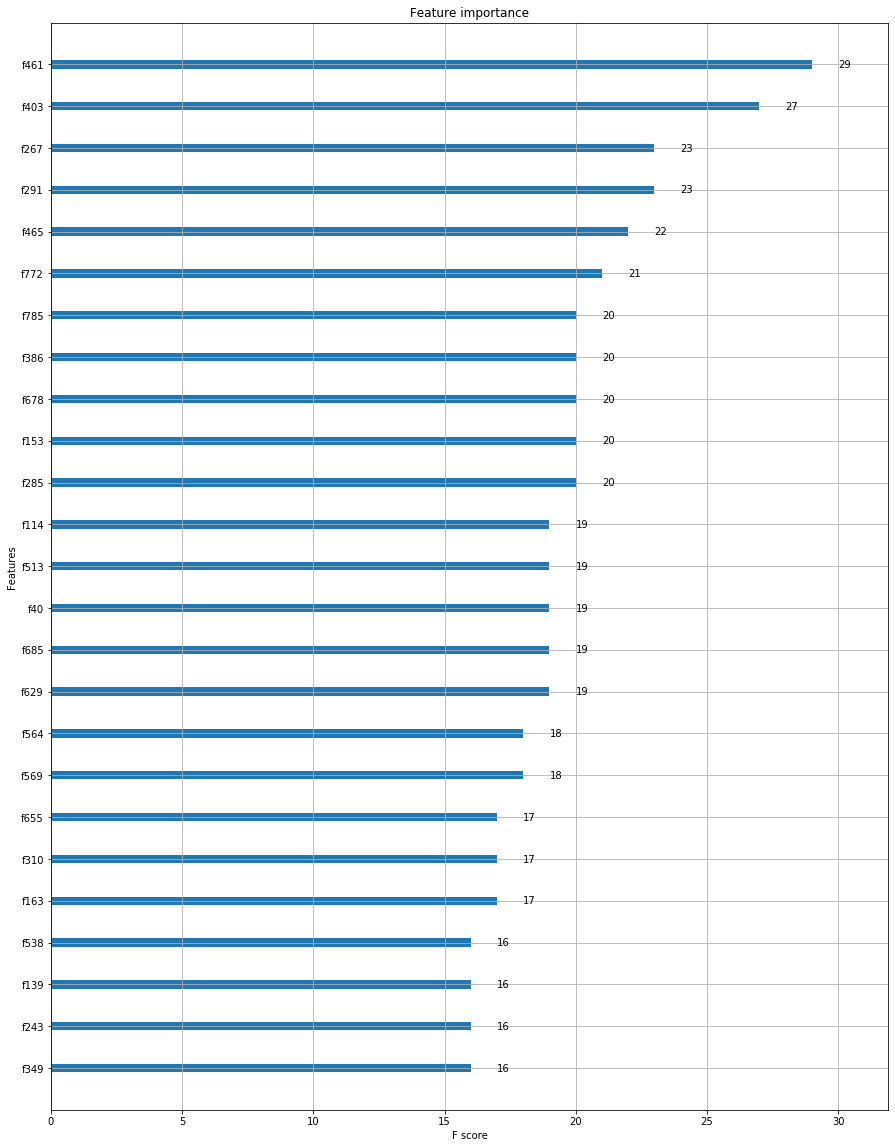

In [60]:
# Get the first indicator
y = list_personality[:,0]

# Fit the model on the training data
model = XGBClassifier()
model.fit(X, y)

# Plot feature importance
ax = plot_importance(model, max_num_features=25)

fig = ax.figure
fig.set_size_inches(15, 20)

plt.show()

In [62]:
# Print the features 

features = sorted(list(enumerate(model.feature_importances_)), key=lambda x: x[1], reverse=True)
for f in features[0:25]:
    print("%d\t%f\t%s" % (f[0],f[1],cntizer.get_feature_names()[f[0]]))
    
# Save xgb_params for late discussuin
default_get_xgb_params = model.get_xgb_params()

222	0.004595	expect
551	0.004560	quiet
122	0.004260	computer
93	0.004210	case
461	0.004159	ne
396	0.003930	listening
690	0.003837	terrible
477	0.003657	nt
438	0.003622	middle
112	0.003487	college
292	0.003386	haha
80	0.003349	boyfriend
434	0.003345	mention
291	0.003298	guy
428	0.003248	meant
249	0.003232	figure
329	0.003190	hug
337	0.003139	image
313	0.003133	hey
581	0.003129	run
719	0.003114	truth
351	0.003087	introvert
235	0.003071	family
244	0.003042	fellow
53	0.002993	awesome


**How to Configure Gradient Boosting**

A number of configuration heuristics were published in the original gradient boosting papers. They can be summarized as:

- Learning rate or shrinkage (learning_rate in XGBoost) should be set to 0.1 or lower, and smaller values will require the addition of more trees.
- The depth of trees (tree_depth in XGBoost) should be configured in the range of 2-to-8, where not much benefit is seen with deeper trees.
- Row sampling (subsample in XGBoost) should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.

In [63]:
# XGB Parameters
default_get_xgb_params = model.get_xgb_params()
print (default_get_xgb_params)

{'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'gpu_id': -1, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'monotone_constraints': '()', 'n_jobs': 0, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


In [64]:
# Set up parameters for xgboost
param = {}

param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

# Train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # Split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # Fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # Make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    # Evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("* %s Accuracy: %.2f%%" % (type_indicators[l], accuracy * 100.0))

IE: Introversion (I) / Extroversion (E) ...
* IE: Introversion (I) / Extroversion (E) Accuracy: 79.01%
NS: Intuition (N) – Sensing (S) ...
* NS: Intuition (N) – Sensing (S) Accuracy: 85.96%
FT: Feeling (F) - Thinking (T) ...
* FT: Feeling (F) - Thinking (T) Accuracy: 74.19%
JP: Judging (J) – Perceiving (P) ...
* JP: Judging (J) – Perceiving (P) Accuracy: 65.42%


**XGBoost Hyperparameter Tuning**

The scikit-learn framework provides the capability to search combinations of parameters. This capability is provided in the GridSearchCV class and can be used to discover the best way to configure the model for top performance on your problem.

The parameters to consider tuning are:

- The number and size of trees (n_estimators and max_depth).
- The learning rate and number of trees (learning_rate and n_estimators).
- The row and column subsampling rates (subsample, colsample_bytree and colsample_bylevel).

In [67]:
# Posts in tf-idf representation
X = X_tfidf

# Set up parameters for xgboost
param = {}

param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

# Train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]
    model = XGBClassifier(**param)
    # learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    # param_grid = dict(learning_rate=learning_rate)

    param_grid = {
        'n_estimators' : [200, 300],
        'learning_rate' : [0.2, 0.3]
        # 'learning_rate': [ 0.01, 0.1, 0.2, 0.3],
        # 'max_depth': [2,3,4],
    }
    
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X, Y)
    
    # Summarize results
    print("* Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("* %f (%f) with: %r" % (mean, stdev, param))

IE: Introversion (I) / Extroversion (E) ...
* Best: -0.496607 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.496607 (0.009291) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.498587 (0.007900) with: {'learning_rate': 0.2, 'n_estimators': 300}
* -0.505122 (0.010825) with: {'learning_rate': 0.3, 'n_estimators': 200}
* -0.512983 (0.010218) with: {'learning_rate': 0.3, 'n_estimators': 300}
NS: Intuition (N) – Sensing (S) ...
* Best: -0.477121 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.477121 (0.012895) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.530521 (0.017500) with: {'learning_rate': 0.2, 'n_estimators': 300}
* -0.548609 (0.025005) with: {'learning_rate': 0.3, 'n_estimators': 200}
* -0.602314 (0.026807) with: {'learning_rate': 0.3, 'n_estimators': 300}
FT: Feeling (F) - Thinking (T) ...
* Best: -0.549636 using {'learning_rate': 0.2, 'n_estimators': 200}
* -0.549636 (0.031440) with: {'learning_rate': 0.2, 'n_estimators': 200}
* -0.576447 (0.037685) w

## Getting Twitter Data

https://github.com/twintproject/twint

In [84]:
 # Set up Twint
c = twint.Config()
c.Username = "AthiyaD"
c.Limit = 1000
c.Store_csv = True
c.Output = "tweets.csv"

In [85]:
twint.run.Search(c)

RuntimeError: This event loop is already running

1265726794801442816 2020-05-28 02:29:18 WIB <AthiyaD> Spending lots of time on Kaggle lately
1265405912174309376 2020-05-27 05:14:14 WIB <AthiyaD> Just made a petty project on using Machine Learning to estimate an influencer’s (or any instagram user's) authenticity, i.e. did they *buy* their likes and followers? Might drop a blog post soon-ish. GitHub:  https://github.com/athiyadeviyani/IGAudit … 😉 #MachineLearning #DataScience #SocialMedia
1265173584651010049 2020-05-26 13:51:03 WIB <AthiyaD> how did i just know about the school of good and evil being turned into a movie?!?! @SomanChainani
1265029081503952896 2020-05-26 04:16:50 WIB <AthiyaD> FaceApp out there to collect your face for machine learning databases y’all
1264952550245060609 2020-05-25 23:12:44 WIB <AthiyaD> "An eye for eye only ends up making the whole world blind."
1263621014098857985 2020-05-22 07:01:41 WIB <AthiyaD> So, what I’m trying to say is that we are all currently going through hell. However, Winston Churchill o

1247501488177344512 2020-04-07 19:28:26 WIB <AthiyaD> In some ways Gossip Girl reminds me of Game of Thrones
1246539677009465349 2020-04-05 03:46:33 WIB <AthiyaD> you can literally do anything to a potato and it will still taste good
1246539563004096519 2020-04-05 03:46:06 WIB <AthiyaD> potatoes are very versatile
1246198345414008832 2020-04-04 05:10:13 WIB <AthiyaD> It’s 5 AM and I just finished stress-coding an app that enlarges instagram display pictures 🤯🥳#JustQuarantineThings  http://athiyadeviyani.github.io/InstaKilo/  (WORKS BEST IN CHROME) pic.twitter.com/RhLOHylcIL
1245665710811963392 2020-04-02 17:53:43 WIB <AthiyaD> “I have so much work to do.” I say every day as I get up at 5pm and proceed staring at the ceiling for another 3 hours
1245009240562888705 2020-03-31 22:25:08 WIB <AthiyaD> What kind of shoes do frogs wear? Open toad!
1244736034996228096 2020-03-31 04:19:31 WIB <AthiyaD> So many people I'd like to ask "do you not like me around anymore?" to 😔
1244665180161597440 

1213808092057493504 2020-01-05 20:02:55 WIB <AthiyaD> Not wanting to know and not caring are two completely different things
1213312698869374977 2020-01-04 11:14:24 WIB <AthiyaD> Imagine being a Hemsworth
1213198498973110272 2020-01-04 03:40:36 WIB <AthiyaD> How (not) to be discrete 101 https://twitter.com/newUstation/status/1213042729946476544 …
1212811008718229504 2020-01-03 02:00:52 WIB <AthiyaD> Sounds like recursion to me 🤩 https://twitter.com/c_aramelle/status/1212784738261442560 …
1212777263386595330 2020-01-02 23:46:46 WIB <AthiyaD> Then onto my summer internship at @Google Zurich, a.k.a. the highlight of my 2019 pic.twitter.com/ZLLu9RpYXT
1212776160314064896 2020-01-02 23:42:23 WIB <AthiyaD> Went to Universal Studios Singapore with my Edinbuddies and rode the Xylon roller coaster TWICE — once in the front most of the coaster 🎢 pic.twitter.com/xpjRw4qq16
1212775115655499777 2020-01-02 23:38:14 WIB <AthiyaD> Went to see my best friends (the real ones) 🤗 pic.twitter.com/OWy920JbY

1195316575101997056 2019-11-15 19:24:14 WIB <AthiyaD> I need a good GPA
1195044415187935232 2019-11-15 01:22:46 WIB <AthiyaD> I want to go home
1194023303989661698 2019-11-12 05:45:14 WIB <AthiyaD> So please, the next time you see a computer scientist coming home from the lab at 7AM looking all dirty and grumpy, don’t laugh — we had a rough night and we know that this is just the start.
1194022766464372737 2019-11-12 05:43:06 WIB <AthiyaD> We also have to do a ridiculous amount of coding challenges and technical interviews while trying to juggle coursework throughout the term
1194022592446914560 2019-11-12 05:42:24 WIB <AthiyaD> I think the informatics career path is ridiculously demanding — we’re expected to do side projects on top of coursework, spring and summer internship, external competitions/seminars, WHILE also graduating Bachelors with at least a 2:1 (equivalent to 60%) honours.
1194021165704056833 2019-11-12 05:36:44 WIB <AthiyaD> The course choices for Artificial Intelligenc

1166434104579186688 2019-08-28 02:35:36 WIB <AthiyaD> Man @13ReasonsWhy hitting us with them character arcs
1166430738729852928 2019-08-28 02:22:14 WIB <AthiyaD> How is anybody supposed to heal if all we do is cover up the wounds and hope that they'll go away?
1166078137035296768 2019-08-27 03:01:07 WIB <AthiyaD> B please u just met emir 😂
1166077785359695881 2019-08-27 02:59:43 WIB <AthiyaD> 😊 https://open.spotify.com/track/1LLXZFeAHK9R4xUramtUKw?si=7Ja2aQeRSwu9-bxWGn6nLQ …
1166058827365650433 2019-08-27 01:44:23 WIB <AthiyaD> don’t get mad GET EVEN speaks to me in a whole new level
1165752979498164226 2019-08-26 05:29:03 WIB <AthiyaD> Is the color grading on this season's #13ReasonsWhy a bit odd or is it just me
1165735881875054594 2019-08-26 04:21:07 WIB <AthiyaD> Okay here’s proof pic.twitter.com/91ZvMkcdi9
1165735774752530434 2019-08-26 04:20:41 WIB <AthiyaD> Went hiking again today but this time there were proper intense uphill trails and I actually broke into a puddle of sweat..

1147805156421066752 2019-07-07 16:50:49 WIB <AthiyaD> right so the plural of gelato is gelati
1146849105416806401 2019-07-05 01:31:48 WIB <AthiyaD> Boat trip around Lake Zurich 💕 pic.twitter.com/VXw3a4qtkw
1146662991741501441 2019-07-04 13:12:15 WIB <AthiyaD> Name a better way to explore Zurich and Google’s Zurich offices! pic.twitter.com/T7Qbab38d5
1145748107285676035 2019-07-02 00:36:50 WIB <AthiyaD>  pic.twitter.com/zrcgL5SFQ4
1145744658674454533 2019-07-02 00:23:08 WIB <AthiyaD> First day at @Google! Great food, amazing people, and a really sick office 🤙🏻 pic.twitter.com/Dy6n4uOtQM
1144862716777160704 2019-06-29 13:58:36 WIB <AthiyaD> Touchdown Switzerland! 🇨🇭
1143568599790940160 2019-06-26 00:16:15 WIB <AthiyaD>  pic.twitter.com/C9vIi6Ws3W
1143541468482564097 2019-06-25 22:28:26 WIB <AthiyaD> Fun fun in sun sun before work starts next Monday 🎉 pic.twitter.com/O9EJ8drShe – di Universal Studios Singapore
1143540978273284096 2019-06-25 22:26:29 WIB <AthiyaD> It’s so difficult not to 

1046455500546723842 2018-10-01 00:43:28 WIB <AthiyaD> happy birthday @adam_tiova enjoy your last year of being a teenager 🤗 pic.twitter.com/yG7I2XpxkM
1044751369033453568 2018-09-26 07:51:51 WIB <AthiyaD> never too late for twitter imo
1044728045733650433 2018-09-26 06:19:10 WIB <AthiyaD> omg so what do you wear if not casual clothes? i literally go in sweatpants everyday
1044727740224733192 2018-09-26 06:17:58 WIB <AthiyaD> woohoo ya girl’s class rep 🎉🎉🎉 pic.twitter.com/VVjJ72Kgu6
1044385183070375936 2018-09-25 07:36:46 WIB <AthiyaD> went to EdUni’s Sing Soc’s first social of the school year. was pretty lit (literally) 🇸🇬 pic.twitter.com/0qmzr9cwBQ
1044384545552957440 2018-09-25 07:34:14 WIB <AthiyaD> probs been ages since i’ve listened to this song but it hits ya right in the feels 😞  https://open.spotify.com/track/6rT0BKAbg4y35tukHcfk4N?si=nR4ueMyHTX6EfWji5d0uJw … pic.twitter.com/zechATBcmE
1044351067767623680 2018-09-25 05:21:12 WIB <AthiyaD> i hate how you still give me the warm f

1021600430042755072 2018-07-24 10:38:17 WIB <AthiyaD> i honestly want to watch a t swift concert at least once in my life
1021599702343544833 2018-07-24 10:35:24 WIB <AthiyaD> IS IT JUST ME OR DO THEY LOOK ALIKE pic.twitter.com/odq15ekklQ
1021229885799493633 2018-07-23 10:05:52 WIB <AthiyaD> where do i go when ‘home' is no longer the place i used to know?
1020605835171454977 2018-07-21 16:46:07 WIB <AthiyaD> #lifeatthebodyshop pic.twitter.com/TpjCm28bTJ
1019950927237693440 2018-07-19 21:23:45 WIB <AthiyaD> if you ever feel dumb go watch a horror movie where the character goes “hello?” as they enter a dark and obviously uninhabited room
1019783089457909760 2018-07-19 10:16:49 WIB <AthiyaD> Join me & sign the petition to ban animal testing for cosmetics forever  http://bit.ly/2q7gkF8  #ForeverAgainstAnimalTesting
1019594697302466561 2018-07-18 21:48:13 WIB <AthiyaD> they obviously haven’t seen The Mummy https://twitter.com/mysteriousuniv/status/1019266878697541632 …
1019593938070429696 2

981971331418902528 2018-04-06 02:06:24 WIB <AthiyaD> you’ve given me no chance but to stay stay stay
981966541611728896 2018-04-06 01:47:22 WIB <AthiyaD> this love our shield, our blade
981716956683423744 2018-04-05 09:15:36 WIB <AthiyaD> if you love what you do it won’t feel like work at all ❤️ pic.twitter.com/IMfnV439Mn
981706247434133504 2018-04-05 08:33:03 WIB <AthiyaD> my happiness; what a fun game it was, for you
981705753319927808 2018-04-05 08:31:05 WIB <AthiyaD> but baby let up, i won’t ever recognize this route; i am lost, but not in you
980475576380248071 2018-04-01 23:02:48 WIB <AthiyaD> naive, i was just staring at the barrel of the gun
980197097105444867 2018-04-01 04:36:13 WIB <AthiyaD> i am very anxious
979801581242773510 2018-03-31 02:24:35 WIB <AthiyaD> I cried watching this cover, it’s insanely touching! Save Myself - Ed Sheeran Cover by Daisy Clark  https://youtu.be/_kAGsFY20qI  via @YouTube
979119977545588738 2018-03-29 05:16:08 WIB <AthiyaD> we spoke in flames and

966871249782632448 2018-02-23 10:04:04 WIB <AthiyaD> #adulthood
966871146745352192 2018-02-23 10:03:39 WIB <AthiyaD> i kinda want the google pixel 2 now, mainly because of the world class selfie cam lol
966304290380840960 2018-02-21 20:31:10 WIB <AthiyaD> 📹 taylorswift: End Game video behind the scenes is out nowww  http://taylor.lk/EndGameBTS   https://tmblr.co/ZFUXQy2VNxkx3 
965671051115016192 2018-02-20 02:34:54 WIB <AthiyaD> why are all third years hot
964903870731300864 2018-02-17 23:46:24 WIB <AthiyaD> he could’ve told the truth... but he decided that it wouldn’t hurt me enough to destroy me
964550926299205632 2018-02-17 00:23:55 WIB <AthiyaD> I just signed this petition. Can you sign too?  https://fb.me/Toea7z9e 
964235360636145664 2018-02-16 03:29:59 WIB <AthiyaD> true love is sending your daughter cupcakes on valentine’s day even though you’re thousands of miles away. i love you mom and dad, to the moon and back and all over again. 💕 pic.twitter.com/eIfmovZk2E
9627280717899817

921831406392750082 2017-10-22 03:11:48 WIB <AthiyaD> mid terms! yay (no.)
921831361106862080 2017-10-22 03:11:37 WIB <AthiyaD> uni is so tiring
920059909143543808 2017-10-17 05:52:30 WIB <AthiyaD> this makes me mad pic.twitter.com/z51wTD3bfX
919345621571657728 2017-10-15 06:34:11 WIB <AthiyaD> also mom sent me a pic of my room earlier today, miss it a lot pic.twitter.com/aTcidr1lyY
919345203277979648 2017-10-15 06:32:31 WIB <AthiyaD> I miss my parents tho pic.twitter.com/EXGaTEseYp – di Edinburgh Castle
919344369571913729 2017-10-15 06:29:12 WIB <AthiyaD> i really love my room here as well pic.twitter.com/7tUvXSPT1s
919343738039820289 2017-10-15 06:26:42 WIB <AthiyaD> im in love with this city pic.twitter.com/yKUPdDzoWT – di Calton Hill
913904238178312192 2017-09-30 06:12:04 WIB <AthiyaD> Describe the cutest thing a guy ever did to you :) — I know whoever asked this question expected a 'cute valentine…  http://l.ask.fm/igoto/45DKECN75V62DDAUPY6IQO7C5OATJNA3Q337FANJD7SKZPN2ZEY5KMYNNRKMS

829372263929573376 2017-02-08 23:52:11 WIB <AthiyaD> if something’s too good to be true, it usually is.
829019505250557952 2017-02-08 00:30:27 WIB <AthiyaD> so stupid of me to think that it was actually possible
828562461326508033 2017-02-06 18:14:19 WIB <AthiyaD> "Maybe it wasn’t anything. Or if it was something, maybe that something didn’t matter anymore."  http://amzn.com/k/nmQ3yaBERCqr_j3YMNjpcw …
828561629545652228 2017-02-06 18:11:01 WIB <AthiyaD> "I couldn’t handle the rejection again."  http://amzn.com/k/8-e-o-d5QCWwC_DSjjsk_g …
827783210360672256 2017-02-04 14:37:51 WIB <AthiyaD> tar lg lulus. masi kaya anak kecil gini disuruh lulus
827780284540071936 2017-02-04 14:26:13 WIB <AthiyaD> if you like chicken nuggets then you gotta sing along, if you like chicken nuggets this is your favourite song
827779372840923136 2017-02-04 14:22:36 WIB <AthiyaD> akhir akhir ini suka senyum senyum sendiri bayangin hidup gue selama 6 bulan ke depan
827482725544239105 2017-02-03 18:43:50 WIB <Ath

781731453671354369 2016-09-30 12:44:37 WIB <AthiyaD> woop curiosity killed le chat
781731388953243648 2016-09-30 12:44:21 WIB <AthiyaD> tell me it’s over
781731033637015552 2016-09-30 12:42:56 WIB <AthiyaD> it’s ok
781731006206226432 2016-09-30 12:42:50 WIB <AthiyaD> will regret this sooner or later but
781697361508610050 2016-09-30 10:29:08 WIB <AthiyaD> duh besök SAT :))))))))))
780735399974936577 2016-09-27 18:46:39 WIB <AthiyaD> ath lo kenapa
780734829050548225 2016-09-27 18:44:23 WIB <AthiyaD> nigh
780481323014160387 2016-09-27 01:57:02 WIB <AthiyaD> 3 people unfollowed me // automatically checked by  http://fllwrs.com 
779948724420157440 2016-09-25 14:40:41 WIB <AthiyaD> Having a good heart is not enough
779711895632646144 2016-09-24 22:59:36 WIB <AthiyaD> I’m trying my hardest to be exactly and all that you need
779699662143889408 2016-09-24 22:11:00 WIB <AthiyaD> It’s all fun and games until feelings came along
779059524762238977 2016-09-23 03:47:19 WIB <AthiyaD> 2 people unfol

762632264995909632 2016-08-08 19:51:15 WIB <AthiyaD> HUMUHUMU OMG I LOVE THIS  https://twitter.com/girlposts/status/762619644607926272 …
762632120216924165 2016-08-08 19:50:41 WIB <AthiyaD> AS results in a couple of days and I'm starting to get really sick... Coincidence much
761596236784869378 2016-08-05 23:14:27 WIB <AthiyaD> one person followed me and 3 people unfollowed me // automatically checked by  http://fllwrs.com 
760509920248594432 2016-08-02 23:17:49 WIB <AthiyaD> Most of the people I do this to just run and never look back pic.twitter.com/SLLXDONGfw
760444286953414656 2016-08-02 18:57:01 WIB <AthiyaD> is this because 5-year-old me stole your fallen money on stage and made u cwy
760200600688717824 2016-08-02 02:48:41 WIB <AthiyaD> 2 people followed me and one person unfollowed me // automatically checked by  http://fllwrs.com 
760130466296901632 2016-08-01 22:10:00 WIB <AthiyaD> FaceBook constantly reminding me that I'm old pic.twitter.com/uOMEYn0Q6X
760129380588761088 2016

In [86]:
tweets = pd.read_csv('tweets.csv')

In [87]:
tweets.shape

(1500, 34)

**Pre-process Tweets**

In [89]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk import word_tokenize

# We want to remove these from the psosts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
  
unique_type_list = [x.lower() for x in unique_type_list]


# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

# Cache the stop words for speed 
cachedStopWords = stopwords.words("english")
def pre_process_tweets(data, remove_stop_words=True, remove_mbti_profiles=True):

    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if (i % 500 == 0 or i == 1 or i == len_data):
            print("%s of %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].tweet
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
            
        if remove_mbti_profiles:
            for t in unique_type_list:
                temp = temp.replace(t,"")

        list_posts.append(temp)

    list_posts = np.array(list_posts)
    return list_posts

In [91]:
list_tweets = pre_process_tweets(tweets)

1 of 1500 rows
500 of 1500 rows
1000 of 1500 rows
1500 of 1500 rows


In [99]:
print(list_tweets[1412])

putting soil back even harder digging hole


## Making the Prediction

In [101]:
my_X_cnt = cntizer.transform(list_tweets)
my_X_tfidf =  tfizer.transform(my_X_cnt).toarray()

Fit and predict the 4 type indicators

In [120]:
# Set up parameters for xgboost
param = {}

param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

result = [] 

# Train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # Split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # Fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # Make predictions for test data
    y_pred = model.predict(my_X_tfidf)
    print(len([i for i in y_pred if i == 1]))
    predictions = [round(value) for value in y_pred]
    
    result.append(y_pred[0])
    

IE: Introversion (I) / Extroversion (E) ...
0
NS: Intuition (N) – Sensing (S) ...
2
FT: Feeling (F) - Thinking (T) ...
1284
JP: Judging (J) – Perceiving (P) ...
1460


In [121]:
print("The result is: ", translate_back(result))

The result is:  INFP


In [130]:
result

[0, 0, 0, 1]

**So... are these results accurate?**

I'm surprised to find that 3/4 of the indicators are correct! I just took the MBTI test at https://www.16personalities.com/ and found out that my Myers-Briggs personality type is ENFP-A.

**Making the prediction on Donald Trump's tweets**

In [106]:
 # Set up Twint
c = twint.Config()
c.Username = "realDonaldTrump"
c.Limit = 1000
c.Store_csv = True
c.Output = "trump_tweets.csv"

In [107]:
twint.run.Search(c)

RuntimeError: This event loop is already running

1265706645134274561 2020-05-28 01:09:14 WIB <realDonaldTrump> WARRANTLESS SURVEILLANCE OF AMERICANS IS WRONG!
1265649545410744321 2020-05-27 21:22:20 WIB <realDonaldTrump> Twitter has now shown that everything we have been saying about them (and their other compatriots) is correct. Big action to follow!
1265633761024188417 2020-05-27 20:19:37 WIB <realDonaldTrump> The Radical Left Lamestream Media, together with their partner, the Do Nothing Democrats, are trying to spread a new narrative that President Trump was slow in reacting to Covid 19. Wrong, I was very fast, even doing the Ban on China long before anybody thought necessary!
1265624335898869760 2020-05-27 19:42:10 WIB <realDonaldTrump> Psycho Joe Scarborough is rattled, not only by his bad ratings but all of the things and facts that are coming out on the internet about opening a Cold Case. He knows what is happening!
1265613475809763328 2020-05-27 18:59:01 WIB <realDonaldTrump> We pass 15,000,000 Tests Today, by far the most in

1264905219265232898 2020-05-25 20:04:39 WIB <realDonaldTrump>  https://www.whitehouse.gov/presidential-actions/proclamation-prayer-peace-memorial-day-2020/ …
1264893630612897792 2020-05-25 19:18:36 WIB <realDonaldTrump> TRANSITION TO GREATNESS! Get ready, it is already happening again!
1264893060774793218 2020-05-25 19:16:20 WIB <realDonaldTrump> HAPPY MEMORIAL DAY!
1264892000052088832 2020-05-25 19:12:08 WIB <realDonaldTrump> ...to find, with all of the jobs and economic development it brings, another Republican National Convention site. This is not something I want to do. Thank you, and I LOVE the people of North Carolina!
1264891999116763139 2020-05-25 19:12:07 WIB <realDonaldTrump> ...made by many thousands of enthusiastic Republicans, and others, to head to beautiful North Carolina in August. They must be immediately given an answer by the Governor as to whether or not the space will be allowed to be fully occupied. If not, we will be reluctantly forced...
1264891998017859584 2020

1264176425311051776 2020-05-23 19:48:41 WIB <realDonaldTrump> ...And Sleepy Joe! https://twitter.com/JesseBWatters/status/1263591146133106688 …
1264171435683176448 2020-05-23 19:28:52 WIB <realDonaldTrump> All things that I have GOTTEN DONE, including Criminal Justice Reform! https://twitter.com/whitehouse/status/1263961553340071938 …
1264170597233426432 2020-05-23 19:25:32 WIB <realDonaldTrump> Sean Parnell is a Star. We need him in Washington to Drain the Swamp! https://twitter.com/realDonaldTrump/status/1263977067080830977 …
1264169908285341698 2020-05-23 19:22:47 WIB <realDonaldTrump> Patriots! https://twitter.com/realDonaldTrump/status/1263919244485550081 …
1264169465681502208 2020-05-23 19:21:02 WIB <realDonaldTrump> So bad! https://twitter.com/realdonaldtrump/status/1263540859145945090 …
1264168501046128640 2020-05-23 19:17:12 WIB <realDonaldTrump> Caught in the act! https://twitter.com/realDonaldTrump/status/1262965636545884166 …
1263981547386011649 2020-05-23 06:54:19 WIB <rea

1263636793972477952 2020-05-22 08:04:23 WIB <realDonaldTrump> THANK YOU! #MAGA pic.twitter.com/hqyNTNoVHi
1263624257113862146 2020-05-22 07:14:34 WIB <realDonaldTrump>  https://hannity.com/media-room/joe-in-trouble-new-poll-shows-trump-beating-biden-in-15-battleground-states/ …
1263600798056906752 2020-05-22 05:41:21 WIB <realDonaldTrump> ....On Monday, the flags will be at half-staff in honor of the men and women in our Military who have made the Ultimate Sacrifice for our Nation.
1263600794290417670 2020-05-22 05:41:20 WIB <realDonaldTrump> I will be lowering the flags on all Federal Buildings and National Monuments to half-staff over the next three days in memory of the Americans we have lost to the CoronaVirus....
1263598954735788034 2020-05-22 05:34:01 WIB <realDonaldTrump> Another $298M heading to @MTA, adding up to over $2B in federal funding from @USDOT so far, part of the $3.9B total from the CARES Act. This is critical to keeping essential personnel moving and aiding metro NY

1262933958041444354 2020-05-20 09:31:34 WIB <realDonaldTrump> So true. OBAMAGATE! https://twitter.com/tedcruz/status/1262833632596627459 …
1262818021329993729 2020-05-20 01:50:52 WIB <realDonaldTrump> THANK YOU @SenateGOP! https://twitter.com/SenateGOP/status/1262784704987742208 …
1262787562206367744 2020-05-19 23:49:50 WIB <realDonaldTrump> “The Massive Trump Coronavirus Supply Effort that the Media Loves to Hate” @RichLowry https://www.nationalreview.com/2020/05/the-massive-trump-coronavirus-supply-effort-that-the-media-loves-to-hate/ …
1262784304767283200 2020-05-19 23:36:54 WIB <realDonaldTrump> I am pleased to announce that the Seattle area’s @SoundTransit will receive over $166M in federal funds from @USDOT to help keep the transit system open & operational, helping get people to work or make necessary trips. These funds help replace lost fare revenue, very important!
1262781715774353410 2020-05-19 23:26:37 WIB <realDonaldTrump> I am proud to announce the Portland Area’s @trimet 

1262158229359992833 2020-05-18 06:09:06 WIB <realDonaldTrump> They, and the Lamestream Media (including Jake), have spent 3 1/2 years illegally smearing me. They got caught! https://twitter.com/ArthurSchwartz/status/1262080991876780033 …
1262156808497631234 2020-05-18 06:03:27 WIB <realDonaldTrump> The most incompetent and corrupt administration in U.S. history! https://twitter.com/KamVTV/status/1262138707454427152 …
1262156409128583168 2020-05-18 06:01:52 WIB <realDonaldTrump> A CNN Faker! https://twitter.com/erictrump/status/1262140168947019777 …
1262155040107704328 2020-05-18 05:56:25 WIB <realDonaldTrump> The number of Coronavirus cases is strongly trending downward throughout the United States, with few exceptions. Very good news, indeed!
1262140755843448832 2020-05-18 04:59:40 WIB <realDonaldTrump>  pic.twitter.com/YHnkBDfS3r
1262130147387494401 2020-05-18 04:17:31 WIB <realDonaldTrump> Wall is going up fast. 184 miles as of today! https://twitter.com/charliekirk11/status/1261602

1260987576300625920 2020-05-15 00:37:20 WIB <realDonaldTrump> Just landed in Pennsylvania, see everyone soon! https://twitter.com/WhiteHouse/status/1260986723271675904 …
1260984775524769798 2020-05-15 00:26:13 WIB <realDonaldTrump> On my way, see you soon! https://twitter.com/RepFredKeller/status/1260940430117650432 …
1260981100806934528 2020-05-15 00:11:36 WIB <realDonaldTrump> On my way to PENNSYLVANIA! pic.twitter.com/knZn9xcwix
1260958236313862151 2020-05-14 22:40:45 WIB <realDonaldTrump>  pic.twitter.com/AMtNByOrL5
1260951768395063298 2020-05-14 22:15:03 WIB <realDonaldTrump> I am proud to announce the first $500M of $3.9B in CARES Act transit funding headed to the NY Metropolitan Transportation Authority. Important funding to keep transit systems clean and operating to get people back to work! Spend it wisely! @NYGovCuomo @NYCMayor
1260938381254701060 2020-05-14 21:21:51 WIB <realDonaldTrump> If I were a Senator or Congressman, the first person I would call to testify about the b

1260158343756341249 2020-05-12 17:42:16 WIB <realDonaldTrump> Ratings way down, show sucks! https://twitter.com/DailyCaller/status/1259596580803481601 …
1260156226224128000 2020-05-12 17:33:51 WIB <realDonaldTrump> OBAMAGATE makes Watergate look small time! https://twitter.com/GreggJarrett/status/1259942621847437312 …
1260155683443441664 2020-05-12 17:31:42 WIB <realDonaldTrump> Sleepy Eyes fails again! https://twitter.com/GreggJarrett/status/1259847573784977408 …
1260155210498015232 2020-05-12 17:29:49 WIB <realDonaldTrump> Big news! https://twitter.com/SaraCarterDC/status/1260035661282738176 …
1260155029253771264 2020-05-12 17:29:06 WIB <realDonaldTrump> Fake Journalists! https://twitter.com/JennaEllisEsq/status/1259975939611602945 …
1260154672268148736 2020-05-12 17:27:41 WIB <realDonaldTrump> A great time to have strong Borders, and we now have the strongest Borders in our history. 182 miles of Border Wall already built! Dems want Open Borders, let EVERYONE IN. No thanks! https://t

1259530309781118980 2020-05-11 00:06:41 WIB <realDonaldTrump> More Fake News, this time from Jimmy Kimmel’s last place show! https://twitter.com/ByronYork/status/1258824383537262592 …
1259496351748014081 2020-05-10 21:51:45 WIB <realDonaldTrump> Thank you to Eli Lake! https://twitter.com/EliLake/status/1259107147251625984 …
1259493483733270530 2020-05-10 21:40:21 WIB <realDonaldTrump> The biggest political crime in American history, by far! https://twitter.com/BuckSexton/status/1259241405274341383 …
1259455786482311168 2020-05-10 19:10:33 WIB <realDonaldTrump> HAPPY MOTHER’S DAY!
1259454594981203968 2020-05-10 19:05:49 WIB <realDonaldTrump> Congratulations to Officer John Catanzara for being elected President of the Chicago Police Union. He always “Gets the Job Done”. #MAGA @foxandfriends
1259451044834217984 2020-05-10 18:51:43 WIB <realDonaldTrump> True! https://twitter.com/TeamTrump/status/1258811656307650561 …
1259450673151836160 2020-05-10 18:50:14 WIB <realDonaldTrump> Thank you M

1257736426206031874 2020-05-06 01:18:26 WIB <realDonaldTrump> Most of the money raised by the RINO losers of the so-called “Lincoln Project”, goes into their own pockets. With what I’ve done on Judges, Taxes, Regulations, Healthcare, the Military, Vets (Choice!) & protecting our great 2A, they should love Trump. Problem is, I BEAT THEM ALL!
1257725719469158401 2020-05-06 00:35:53 WIB <realDonaldTrump> Remember this? Happy #CincoDeMayo! https://twitter.com/realDonaldTrump/status/728297587418247168 …
1257715551729676289 2020-05-05 23:55:29 WIB <realDonaldTrump> The Do Nothing Democrats and their leader, the Fake News Lamestream Media, are doing everything possible to hurt and disparage our Country. No matter what we do or say, no matter how big a win, they report that it was a loss, or not good enough. The Enemy of the People!
1257714716492722176 2020-05-05 23:52:10 WIB <realDonaldTrump> For the constant criticism from the Do Nothing Democrats and their Fake News partners, here is the ne

1256911953903202307 2020-05-03 18:42:16 WIB <realDonaldTrump> .@PeteHegseth  “Oh bye the way, I appreciate the message from former President Bush, but where was he during Impeachment calling for putting partisanship aside.” @foxandfriends  He was nowhere to be found in speaking up against the greatest Hoax in American history!
1256788149113520129 2020-05-03 10:30:19 WIB <realDonaldTrump> Beautiful, thank you to our GREAT @BlueAngels and @AFThunderbirds! https://twitter.com/WhiteHouse/status/1256728939663425536 …
1256721351722876933 2020-05-03 06:04:53 WIB <realDonaldTrump> No reason to turn it down, except politics. We have plenty of testing. Maybe you need a new Doctor over there. Crazy Nancy will use it as an excuse not to show up to work! https://twitter.com/senatemajldr/status/1237391198328745984 …
1256720284540981248 2020-05-03 06:00:39 WIB <realDonaldTrump> The Democrats are just, as always, looking for trouble. They do nothing constructive, even in times of crisis. They don’t wa

1255837028526297088 2020-04-30 19:30:54 WIB <realDonaldTrump> Great! https://twitter.com/GenFlynn/status/1255645641105182722 …
1255832117583495169 2020-04-30 19:11:23 WIB <realDonaldTrump> DIRTY COP JAMES COMEY GOT CAUGHT!
1255829937690480643 2020-04-30 19:02:43 WIB <realDonaldTrump> Plus many! https://twitter.com/TomFitton/status/1255676634721632256 …
1255829082660577283 2020-04-30 18:59:20 WIB <realDonaldTrump> Really? Have you looked at the numbers lately! https://twitter.com/mitchellvii/status/1255798948461187073 …
1255828428814770176 2020-04-30 18:56:44 WIB <realDonaldTrump> FAKE POLLING, just like 2016 (but worse)!
1255826177350144001 2020-04-30 18:47:47 WIB <realDonaldTrump> What happened to General Michael Flynn, a war hero, should never be allowed to happen to a citizen of the United States again!
1255825998521741312 2020-04-30 18:47:04 WIB <realDonaldTrump> Does anybody really believe that Roger Stone, a man whose house was raided early in the morning by 29 gun toting FBI Age

1254060573655998466 2020-04-25 21:51:54 WIB <realDonaldTrump> It is a wonderful feeling to know that our States are loaded up with Ventilators, many brand new and high quality just off of our production lines, and that we are now in a position to help other countries that so desperately need them. Every person needing a Ventilator got one!
1254050117767880706 2020-04-25 21:10:21 WIB <realDonaldTrump> Just spoke to Prime Minister Abiy Ahmed Ali of Ethiopia. His Country needs Ventilators, and the U.S. is in good position to help him. We will!
1254032243770736642 2020-04-25 19:59:20 WIB <realDonaldTrump> Many testing sites are, and have been, open & available. Just passed 5 Million Tests, far more than any other country in the world. In fact, more than all other major countries combined! Don’t believe the Fake News! https://twitter.com/CDCgov/status/1253768673338118144 …
1254028869859971072 2020-04-25 19:45:55 WIB <realDonaldTrump> Thank you to the people of Colorado for the warm and grac

In [113]:
trump_tweets = pd.read_csv('trump_tweets.csv')

In [114]:
trump_tweets

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1265706645134274561,1265706645134274561,1590602954000,2020-05-28,01:09:14,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
1,1265649545410744321,1265649545410744321,1590589340000,2020-05-27,21:22:20,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
2,1265633761024188417,1265633761024188417,1590585577000,2020-05-27,20:19:37,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
3,1265624335898869760,1265624335898869760,1590583330000,2020-05-27,19:42:10,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
4,1265613475809763328,1265613475809763328,1590580741000,2020-05-27,18:59:01,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1240269231410774016,1240269212871995393,1584538202000,2020-03-18,20:30:02,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
996,1240269212871995393,1240269212871995393,1584538198000,2020-03-18,20:29:58,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
997,1240265729108303873,1240265729108303873,1584537367000,2020-03-18,20:16:07,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN
998,1240243188708839424,1240243188708839424,1584531993000,2020-03-18,18:46:33,WIB,25073877,realdonaldtrump,Donald J. Trump,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '25073877', 'username': 'realDona...",NaN,NaN,NaN,NaN


In [125]:
trump_processed_tweets = pre_process_tweets(trump_tweets)

1 of 1000 rows
500 of 1000 rows
1000 of 1000 rows


In [126]:
trump_processed_tweets

array(['warrantless surveillance american wrong ',
       'twitter shown everything saying compatriot correct big action follow ',
       'radical left lamestream medium together partner nothing democrat trying spread new narrative president trump slow reacting covid wrong fast even ban china long anybody thought necessary ',
       'psycho joe scarborough rattled bad rating thing fact coming internet opening cold case know happening ',
       'pas test today far world open safely ',
       'acting police force fighting force afghanistan year time police country bring soldier back home closely watch going strike thunder like never necessary ',
       'obamagate make watergate look like small potato ',
       'new paper make clear obama administration spied unprecedented manner trump campaign beyond even united state senate nobody would ever believed level illegality corruption would taking place beautiful usa ',
       'informed india china united state ready willing able mediate arbit

In [127]:
t_X_cnt = cntizer.transform(trump_processed_tweets)
t_X_tfidf =  tfizer.transform(t_X_cnt).toarray()

In [131]:
# Set up parameters for xgboost
param = {}

param['n_estimators'] = 200
param['max_depth'] = 2
param['nthread'] = 8
param['learning_rate'] = 0.2

trump_result = [] 

# Train type indicator individually
for l in range(len(type_indicators)):
    print("%s ..." % (type_indicators[l]))
    
    Y = list_personality[:,l]

    # Split data into train and test sets
    seed = 7
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

    # Fit model on training data
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    # Make predictions for test data
    y_pred = model.predict(t_X_tfidf)
    
    print(len([i for i in y_pred if i==1]))
    
    predictions = [round(value) for value in y_pred]
    
    trump_result.append(y_pred[0])
    

IE: Introversion (I) / Extroversion (E) ...
0
NS: Intuition (N) – Sensing (S) ...
1
FT: Feeling (F) - Thinking (T) ...
786
JP: Judging (J) – Perceiving (P) ...
969


In [132]:
result

[0, 0, 0, 1]

In [135]:
print("The result is: ", translate_back(result))

The result is:  INFP


Haha, the model thinks Trump and I have the same Myers-Briggs personality type based on our tweets... Do you think so?